<a href="https://colab.research.google.com/github/muharyaanandas/CNN-Waste-Classification/blob/main/MobileNet%20(2)_Adam%20(Adaptive%20Moment%20Estimation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Read all image types

def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

In [ ]:
import os, glob, cv2, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

In [ ]:
# Directory paths
dataset_dir = '/content/drive/MyDrive/Klasifikasi_Sampah/Dataset'
dirs = os.listdir(dataset_dir)
class_label = 0
images = []
labels = []
data_list = []
class_list = []

for dir_name in dirs:
    img_count = 0
    path = os.path.join(dataset_dir, dir_name)
    for image_file in glob.glob(os.path.join(path, '*')):
        img = cv2.imread(image_file)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img_count += 1
            data_list.append(img)
            labels.append(class_label)
    print(f"Total {dir_name} images: {img_count}")
    class_label += 1
    class_list.append(dir_name)

data_array = np.array(data_list) / 255.0
labels_array = np.array(labels)

Total Organik images: 100
Total Anorganik images: 109
Total B3 images: 101


In [ ]:
# Encode labels
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
encoded_labels = label_binarizer.fit_transform(labels_array)

# Splitting dataset
X_train, X_test, Y_train, Y_test = train_test_split(data_array, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=24)

# MobileNet as base model
mobilenet_base = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
net_output = mobilenet_base.output
net_output = GlobalAveragePooling2D()(net_output)
net_output = Dense(128, activation='relu')(net_output)
final_output = Dense(3, activation='softmax')(net_output)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Constructing final model
final_model = Model(inputs=mobilenet_base.input, outputs=final_output)

# Freezing base layers
for layer in mobilenet_base.layers:
    layer.trainable = False

# Data augmentation
augmenter = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

# Model compilation
initial_learning_rate = 0.001
optimizer = Adam(lr=initial_learning_rate)
final_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# Model checkpoint setup
checkpoint_dir = '/content/drive/MyDrive/Klasifikasi_Sampah/MobileNet/Epoch_25_Adam/Model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True, monitor='val_accuracy', mode='max')

# Model training
training_history = final_model.fit_generator(
    augmenter.flow(X_train, Y_train, batch_size=35),
    steps_per_epoch=len(X_train) // 35,
    epochs=25,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoint]
)

print("Highest Training Accuracy:", max(training_history.history['accuracy']))
print("Highest Validation Accuracy:", max(training_history.history['val_accuracy']))

<ipython-input-8-f4019424f210>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history = final_model.fit_generator(


Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 1.1795 - accuracy: 0.5023

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 21s 3s/step - loss: 1.1795 - accuracy: 0.5023 - val_loss: 0.9214 - val_accuracy: 0.5161
Epoch 2/25
7/7 [==============================] - 19s 3s/step - loss: 0.6189 - accuracy: 0.7230 - val_loss: 0.7451 - val_accuracy: 0.7742
Epoch 3/25
7/7 [==============================] - 24s 4s/step - loss: 0.4848 - accuracy: 0.8028 - val_loss: 0.7032 - val_accuracy: 0.7097
Epoch 4/25
7/7 [==============================] - 16s 2s/step - loss: 0.3564 - accuracy: 0.8592 - val_loss: 0.6004 - val_accuracy: 0.7419
Epoch 5/25
7/7 [==============================] - 17s 2s/step - loss: 0.2805 - accuracy: 0.9202 - val_loss: 0.5369 - val_accuracy: 0.8065
Epoch 6/25
7/7 [==============================] - 20s 3s/step - loss: 0.1834 - accuracy: 0.9510 - val_loss: 0.5239 - val_accuracy: 0.8065
Epoch 7/25
7/7 [==============================] - 17s 2s/step - loss: 0.1390 - accuracy: 0.9624 - val_loss: 0.4778 - val_accuracy: 0.8226
Epoch 8/25
7/7 [=============================

In [ ]:
# Load and evaluate the trained model
trained_model = tf.keras.models.load_model(checkpoint_dir)
train_predictions = trained_model.predict(X_train)
predicted_labels = np.argmax(train_predictions, axis=1)
true_labels = np.argmax(Y_train, axis=1)

print(classification_report(true_labels, predicted_labels))
print("Training Set Accuracy:", accuracy_score(true_labels, predicted_labels))

8/8 [==============================] - 11s 1s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      0.98      0.99        87
           2       0.98      1.00      0.99        81

    accuracy                           0.99       248
   macro avg       0.99      0.99      0.99       248
weighted avg       0.99      0.99      0.99       248

Training Set Accuracy: 0.9919354838709677


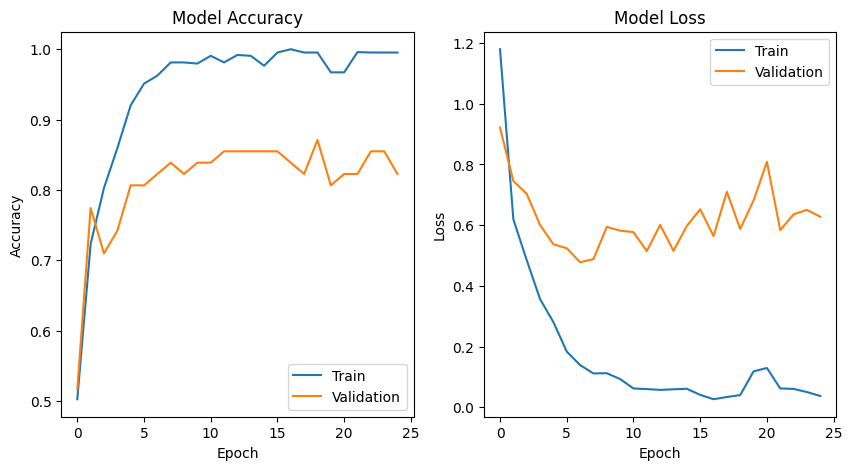

In [ ]:
# Model conversion to TensorFlow Lite format
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)
tflite_model = tflite_converter.convert()
tflite_model_path = '/content/drive/MyDrive/Klasifikasi_Sampah/MobileNet/Epoch_25_Adam/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Plotting training results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Train')
plt.plot(training_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Train')
plt.plot(training_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()